In [ ]:
# install machine gnostics

# recommended to run in a new virtual environment

# !pip install machinegnostics

# Uncertainty Analysis

Example: Pressure measurements from a Pulsating Heat Pipe experiment. In this scenario, data collection is limited because each experiment is time-consuming and costly. As a result, obtaining a large number of repeated measurements is impractical. To address the inherent uncertainty in such small, expensive datasets, we apply Machine Gnostics interval analysis for robust and interpretable uncertainty quantification.



In [2]:
# pressure data from PHP experiment
import numpy as np
data = np.array([0.75, 0.75, 0.71, 0.69, 0.79])

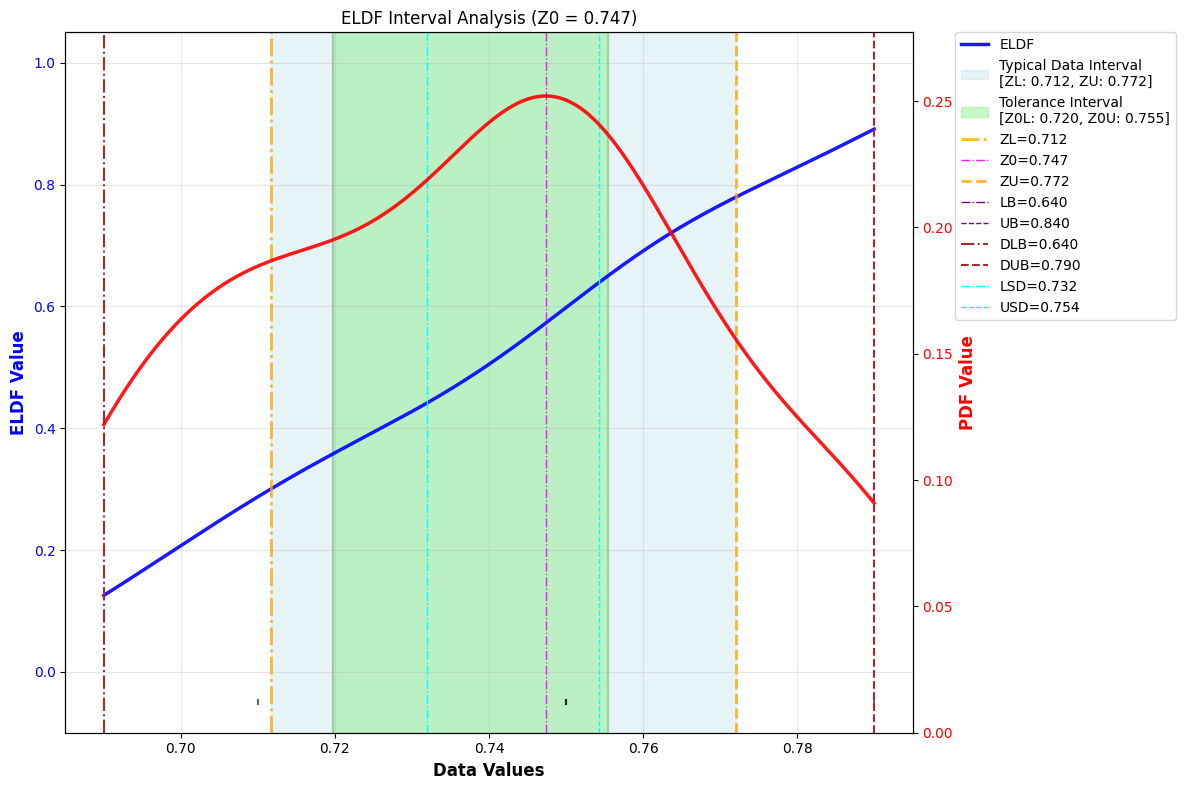

In [3]:
from machinegnostics.magcal import IntervalAnalysis

# create interval analysis object
ia = IntervalAnalysis(wedf=False)

# fit the data
intervals = ia.fit(data, plot=True)


In [4]:
# print intervals
# data certification
ia.results()

{'LB': 0.6400171849777715,
 'LSB': 0.6874649988767415,
 'DLB': 0.69,
 'LCB': 0.69,
 'LSD': 0.731956131559339,
 'ZL': 0.7116723690326949,
 'Z0L': 0.71970871582431,
 'Z0': 0.7474,
 'Z0U': 0.7554738466002175,
 'ZU': 0.7720238355122415,
 'USD': 0.7543153893076004,
 'UCB': 0.7895000000000001,
 'DUB': 0.79,
 'USB': 0.7925350011232585,
 'UB': 0.8399393052912193}

In [5]:
# Get interval results
results = ia.results()

# Extract values
Z0 = results['Z0']      # Mean value (center)
Z0L = results['Z0L']    # Tolerance interval lower
Z0U = results['Z0U']    # Tolerance interval upper
ZL = results['ZL']      # Typical data interval lower
ZU = results['ZU']      # Typical data interval upper

# Tolerance intervals
tolerance_interval = Z0U - Z0L
typical_data_interval = ZU - ZL

print(f"Mean (Z0): {Z0}")
print(f"Tolerance Interval: [{Z0L}, {Z0U}] with width {tolerance_interval}")
print(f"Typical Data Interval: [{ZL}, {ZU}] with width {typical_data_interval}")


Mean (Z0): 0.7474
Tolerance Interval: [0.71970871582431, 0.7554738466002175] with width 0.035765130775907594
Typical Data Interval: [0.7116723690326949, 0.7720238355122415] with width 0.06035146647954659


# GDF vs. 95% Statistical Expanded Uncertainty
This plot compares Machine Gnostics intervals (typical and tolerance) with a conventional 95% statistical expanded uncertainty for the mean. The expanded uncertainty uses a Student-t coverage factor to account for small-sample effects.

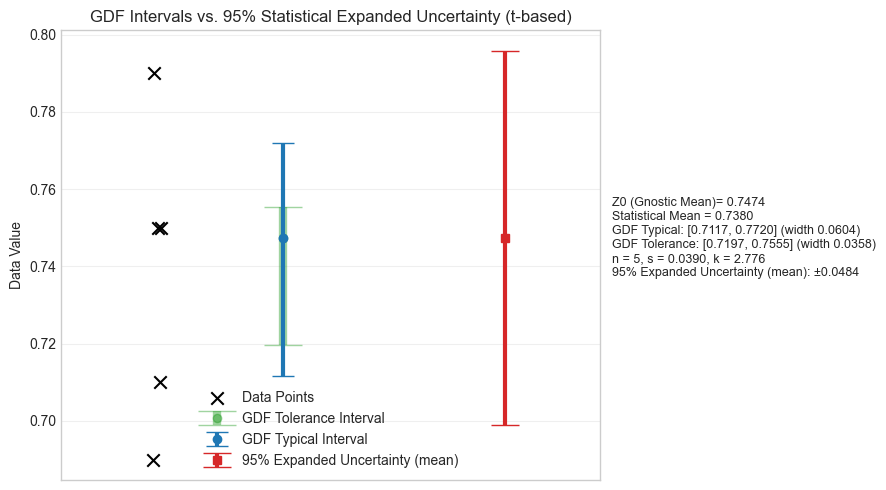

In [9]:
# Compare GDF intervals with 95% statistical expanded uncertainty
import numpy as np
import matplotlib.pyplot as plt

# Try to use Student-t coverage factor; fallback to normal approx if SciPy unavailable
try:
    from scipy.stats import t
    has_scipy = True
except Exception:
    has_scipy = False

# Existing results from IntervalAnalysis
# Z0 (mean/center), Z0L/Z0U (tolerance), ZL/ZU (typical) should already be defined above
n = len(data)
s = np.std(data, ddof=1)            # sample std dev
u_mean = s / np.sqrt(n)              # standard uncertainty of the mean
k = t.ppf(0.975, df=n-1) if has_scipy else 1.96  # 95% coverage factor
U95 = k * u_mean                     # expanded uncertainty (mean ± U95)

# GDF intervals around Z0
typical_lower = Z0 - ZL
typical_upper = ZU - Z0
tolerance_lower = Z0 - Z0L
tolerance_upper = Z0U - Z0

# Plotting
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(9, 5))

x_data = 0.8      # data points
x_gdf = 1.0       # GDF intervals
x_stat = 1.35     # statistical expanded uncertainty

# Data points (slight horizontal jitter for visibility)
rng = np.random.default_rng(7)
jitter = (rng.random(len(data)) - 0.5) * 0.02
ax.scatter([x_data + j for j in jitter], data, color='black', marker='x', s=80, label='Data Points', zorder=3)

# GDF tolerance interval (thick, behind)
ax.errorbar(x_gdf, Z0,
            yerr=[[tolerance_lower], [tolerance_upper]],
            fmt='o', markersize=6, capsize=14, elinewidth=6,
            color='tab:green', alpha=0.45, label='GDF Tolerance Interval', zorder=1)

# GDF typical interval (in front)
ax.errorbar(x_gdf, Z0,
            yerr=[[typical_lower], [typical_upper]],
            fmt='o', markersize=6, capsize=8, elinewidth=3,
            color='tab:blue', label='GDF Typical Interval', zorder=2)

# 95% statistical expanded uncertainty for the mean (t-based if available)
ax.errorbar(x_stat, Z0,
            yerr=[[U95], [U95]],
            fmt='s', markersize=6, capsize=10, elinewidth=3,
            color='tab:red', label='95% Expanded Uncertainty (mean)', zorder=2)

# Cosmetic tweaks
ax.set_xlim(0.65, 1.5)
ax.set_xticks([])
ax.set_ylabel('Data Value')
title_note = 't-based' if has_scipy else 'normal approx'
ax.set_title(f'GDF Intervals vs. 95% Statistical Expanded Uncertainty ({title_note})')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# Annotate values for clarity
txt = [
    f"Z0 (Gnostic Mean)= {Z0:.4f}",
    f"Statistical Mean = {np.mean(data):.4f}",
    f"GDF Typical: [{ZL:.4f}, {ZU:.4f}] (width {ZU - ZL:.4f})",
    f"GDF Tolerance: [{Z0L:.4f}, {Z0U:.4f}] (width {Z0U - Z0L:.4f})",
    f"n = {n}, s = {s:.4f}, k = {k:.3f}",
    f"95% Expanded Uncertainty (mean): ±{U95:.4f}"
]
ax.text(1.52, Z0, '\n'.join(txt), va='center', fontsize=9)

plt.tight_layout()
plt.show()